# Conformalized Early Stopping -- Anomaly Detection

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Some useful functions

In [2]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]


# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
#     # unnormalize
#     invTrans = transforms.Compose([ transforms.Normalize(mean = [0.0],
#                                                          std = [ 1/0.5]),
#                                     transforms.Normalize(mean = [ -0.5 ],
#                                                          std = [ 1.]),
#                                    ])

#     img = invTrans(img)
    # Convert tensor to numpy array
    npimg = img.cpu().numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    


def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()


In [3]:
import torch as th
import numpy as np

from tqdm import tqdm
import torchvision
import matplotlib.pyplot as plt

In [4]:
import sys, os

In [5]:
sys.path.append('../ConformalizedES')

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
from torchvision import transforms
from torchvision import datasets

In [8]:
# Download the MNIST Dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=0.5, std=0.5)])

train_set_full = datasets.MNIST(root = "./data", train = True, download = True, transform=transform)
test_set_full = datasets.MNIST(root = "./data", train = False, download = True, transform=transform)

## Customized dataloader class 
The following dataloader class is modified from https://gist.github.com/Miladiouss/6ba0876f0e2b65d0178be7274f61ad2f.

This customized dataloader enables us to selected subset of the full MNIST data with desired labels.
Here we will take label 0 data as inliers for training and label 1 data as outliers for testing.

In [9]:
from torch.utils.data import Dataset, DataLoader
# Transformations
RC = transforms.RandomCrop(32, padding=4)
RHF = transforms.RandomHorizontalFlip()
RVF = transforms.RandomVerticalFlip()
NRM = transforms.Normalize([0.5], [0.5])
TT = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug = transforms.Compose([TPIL, TT])

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:, 0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]

    return x_i


class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc=transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc

    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)

        return img, class_label

    def __len__(self):
        return sum(self.lengths)

    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

In [10]:
x_train_full = train_set_full.data
y_train_full = train_set_full.targets
x_test_full = test_set_full.data
y_test_full = test_set_full.targets

In [11]:
# Train set composed only of number 0
train_set = \
    DatasetMaker(
        [get_class_i(x_train_full, y_train_full, 0)]
    )

# Test set is a mixture of number 0 and 1
test_set = \
    DatasetMaker(
        [get_class_i(x_test_full, y_test_full, 0),
        get_class_i(x_test_full, y_test_full, 8),
]
    )

print('total number of available training data is: {:d}.'.format(len(train_set)))
print('total number of test data is {:d} in which {:d} are label 0 test data, {:d} are label 8 test data.'\
      .format(len(test_set), test_set.lengths[0],test_set.lengths[1]))

total number of available training data is: 5923.
total number of test data is 1954 in which 980 are label 0 test data, 974 are label 8 test data.


## Randomly plot some images

In [12]:
example_loader = th.utils.data.DataLoader(test_set, shuffle=True, batch_size=4, num_workers=0)
dataiter = iter(example_loader)
images, labels = next(dataiter)

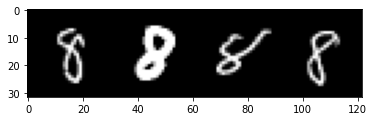

In [13]:
imshow(torchvision.utils.make_grid(images))

# Train Autoencoder

In [14]:
sys.path.append('../ConformalizedES')
sys.path.append('../third_party')

In [15]:
from method import CES_oneClass
from networks import ConvAutoencoder

In [16]:
# Define the model parameters

net = ConvAutoencoder()
lr = 0.01
n_epoch = 10
batch_size = 10

In [17]:
import torch.optim as optim

# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
Loss = th.nn.MSELoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, inputs)
optimizer = optim.Adam(net.parameters(), lr=lr)

In [18]:
seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

In [19]:
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0

seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

n_training_samples = 2000 # Max training number: 5923
n_val_samples = 1000
n_test_samples = 1000 # Max: 2115

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

In [20]:
def get_train_loader(batch_size):
    return th.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

train_loader = get_train_loader(batch_size)

# Use larger batch size for validation to speed up computation
val_loader = th.utils.data.DataLoader(train_set, batch_size=100, sampler=val_sampler,
                                          num_workers=num_workers)

In [21]:
seed = 2023
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_oc = CES_oneClass(net, device, train_loader, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader, criterion=criterion,optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 10
learning_rate= 0.01


In [22]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_oc.full_train(save_dir = './models/oneClass', save_every = save_every)

Epoch 1 of 10, 10% 	 train_loss: 0.19  took: 0.23s
Epoch 1 of 10, 20% 	 train_loss: 0.09  took: 0.15s
Epoch 1 of 10, 30% 	 train_loss: 0.06  took: 0.14s
Epoch 1 of 10, 40% 	 train_loss: 0.06  took: 0.15s
Epoch 1 of 10, 50% 	 train_loss: 0.05  took: 0.14s
Epoch 1 of 10, 60% 	 train_loss: 0.04  took: 0.13s
Epoch 1 of 10, 70% 	 train_loss: 0.04  took: 0.15s
Epoch 1 of 10, 80% 	 train_loss: 0.04  took: 0.15s
Epoch 1 of 10, 90% 	 train_loss: 0.04  took: 0.13s
Epoch 1 of 10, 100% 	 train_loss: 0.04  took: 0.15s
val_loss = 0.04
Snapshot saved at epoch 1.
Epoch 2 of 10, 10% 	 train_loss: 0.04  took: 0.15s
Epoch 2 of 10, 20% 	 train_loss: 0.04  took: 0.16s
Epoch 2 of 10, 30% 	 train_loss: 0.03  took: 0.13s
Epoch 2 of 10, 40% 	 train_loss: 0.03  took: 0.15s
Epoch 2 of 10, 50% 	 train_loss: 0.03  took: 0.13s
Epoch 2 of 10, 60% 	 train_loss: 0.03  took: 0.15s
Epoch 2 of 10, 70% 	 train_loss: 0.03  took: 0.15s
Epoch 2 of 10, 80% 	 train_loss: 0.03  took: 0.15s
Epoch 2 of 10, 90% 	 train_loss: 0.03 

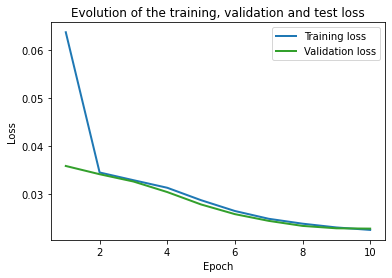

In [23]:
plot_loss(CES_oc.train_loss_history, CES_oc.val_loss_history)

# Select best models and compute conformal p-values

## Check the benchmark model
select_model function will choose the best model for given test point, if no test point
is given, it will output the best model selected ONLY based on validation data, which
serves as an benchmark model.

In [24]:
# check the benchmark model
bm_loss, bm_model, loss_history = CES_oc.select_model()

In [25]:
# Benchmark model corresponds to the one with smallest validation loss
print('Benchmark best loss is: {:.3f}'.format(bm_loss))
print('Benchmark best model is saved in:', bm_model)

Benchmark best loss is: 0.023
Benchmark best model is saved in: ./models/oneClass\model10.pth


# Select best models for each test point

In [26]:
import time

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

n_test_samples = 1800

test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test_samples, sampler=test_sampler,
                                         num_workers=num_workers)

# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

In [27]:
# Pick the best model for each test point
start = time.time()
best_loss, best_model, test_val_loss_history = CES_oc.select_model(inputs)
print('selecting models takes:', time.time()-start)

100%|████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:00<00:00, 2108.17it/s]

selecting models takes: 8.428017377853394


In [28]:
from inference import Conformal_PVals

model_list = CES_oc.model_list

# Compute conformity scores of calibration sets for each model
# this initialization will be a one-time effort.
cal_time = time.time()
C_PVals = Conformal_PVals(net, device, val_loader, model_list, random_state = 2023)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.94it/s]

Initialization done!
Calibration (one time effort) takes:2.03s.


## Check the anomaly scores of inliers and outliers

<function matplotlib.pyplot.show(close=None, block=None)>

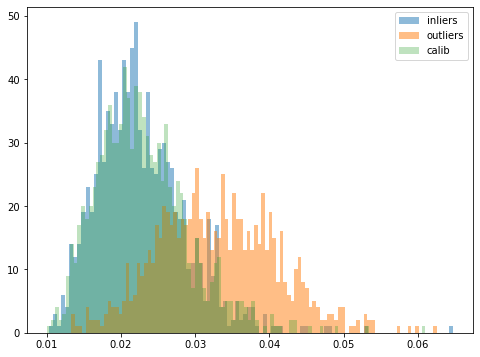

In [29]:
idx_in = np.where(labels==0)[0]
idx_out = np.where(labels==1)[0]
inputs_in = inputs[idx_in]
inputs_out = inputs[idx_out]
scores_in = net.get_anomaly_scores(inputs_in)
scores_out = net.get_anomaly_scores(inputs_out)

plt.figure(figsize=(8,6))
plt.hist(scores_in, bins=100, alpha=0.5, label="inliers")
plt.hist(scores_out, bins=100, alpha=0.5, label="outliers")
plt.hist(C_PVals.cal_scores[9], bins=100, alpha=0.3, label="calib")

plt.legend()
plt.show

## Compute the conformal p-values

In [30]:
pvals = C_PVals.compute_pvals(inputs, best_model)

100%|█████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:02<00:00, 884.36it/s]

Finished computing p-values for 1800 test points.


Average p-value for inliers is 0.506427, average p-value for outliers is 0.155888.


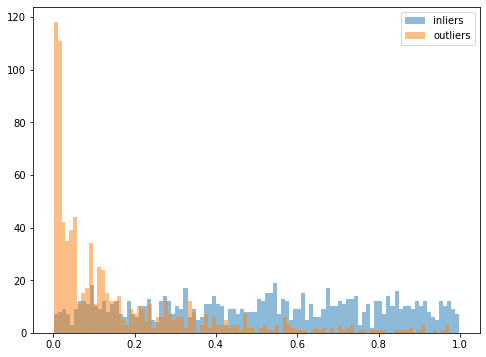

In [36]:
pvals_in = np.array(pvals)[idx_in]
pvals_out = np.array(pvals)[idx_out]

plt.figure(figsize=(8,6))
plt.hist(pvals_in, bins=100, alpha=0.5, label="inliers")
plt.hist(pvals_out, bins=100, alpha=0.5, label="outliers")
plt.legend()
plt.show

print('Average p-value for inliers is {:3f}, average p-value for outliers is {:3f}.'\
      .format(np.mean(pvals_in), np.mean(pvals_out)))

In [44]:
from statsmodels.stats.multitest import multipletests

# Apply BH
alpha = 0.1
purity_test = len(idx_in)/len(pvals)
reject, _, _, _ = multipletests(pvals, alpha=alpha/(1-purity_test), method='fdr_bh')

# Evaluate FDP and Power
rejections = np.sum(reject)
if rejections > 0:
    fdp = np.sum(reject[idx_in])/reject.shape[0] 
    power = np.sum(reject[idx_out])/len(idx_out)
else:
    fdp = 0
    power = 0

print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))

Apply BH procedure yields FDP 0.018889, power 0.418293.
